In [2]:
%matplotlib inline
import torch
import torchvision
from IPython import display
from torchvision import transforms 
from torch.utils import data 
from d2l import torch as d2l
from torch import nn


In [3]:
def get_fashion_minst_labels( labels ):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [ text_labels[i] for i in labels ]

In [4]:
def load_data_fashion_minst( batch_size ,resize = None ):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert( 0 , transforms.Resize( resize ))
    trans = transforms.Compose( trans )
    mnist_train = torchvision.datasets.FashionMNIST( root= '../data' ,train=True, transform=trans )
    mnist_test  = torchvision.datasets.FashionMNIST( root= '../data' ,train=False, transform= trans )
    return( data.DataLoader( mnist_train, batch_size = batch_size , shuffle=True , num_workers=4) ,
            data.DataLoader( mnist_test , batch_size = batch_size , shuffle=True, num_workers= 4) )


In [5]:
batch_size = 18
train_iter,test_iter = load_data_fashion_minst( batch_size)
for train_features,train_labels in train_iter:
    print( train_features.shape , train_labels.shape)
    break

torch.Size([18, 1, 28, 28]) torch.Size([18])


In [6]:
num_inputs = 784
num_outputs = 10
w = torch.normal( 0,0.01 , size=( num_inputs , num_outputs) ,requires_grad = True )#W为784*10的一个矩阵
b = torch.zeros( num_outputs ,requires_grad= True)#偏置为有十个元素的行向量
w,b

(tensor([[-0.0039, -0.0041, -0.0239,  ...,  0.0056, -0.0053, -0.0201],
         [ 0.0065,  0.0073,  0.0073,  ..., -0.0232,  0.0037,  0.0139],
         [-0.0036, -0.0046,  0.0002,  ...,  0.0023,  0.0024, -0.0197],
         ...,
         [ 0.0099, -0.0083, -0.0048,  ...,  0.0201, -0.0023,  0.0063],
         [ 0.0012,  0.0114,  0.0049,  ...,  0.0127,  0.0015, -0.0008],
         [-0.0033,  0.0067, -0.0127,  ...,  0.0022, -0.0066,  0.0207]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

* **定义softmax函数**

In [7]:
def softmax( x ):
    x_exp = torch.exp(x)
    partion = x_exp.sum(1 , keepdim = True )
    # print( partion )
    return x_exp/partion #对输入进来的batch_size*10的数据进行exp操作，然后对每一行作sum操作得到一个batch_size的行向量

* **定义模型**

In [8]:
def net( x ):
    return softmax(torch.matmul( x.reshape( -1 , w.shape[0] ) , w ) + b ) #返回一个batchsize*10的矩阵，实际上一行向量就是y的输出，其中
                                                                    #最大的那个值对应的下标就是输出的标签
                                                

* **定义损失函数**

In [9]:
def cross_entropy( y_hat , y):
    return - torch.log( y_hat[range(len( y_hat )) , y ] ) #y值必须是int类型才能取值

* **定义sgd**

In [10]:
# def sgd( params , lr  , batch_size ):
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad  /batch_size#这里除掉一个batch_size的原因是因为在下面的loss函数中做了一次sum，也就是得到了一
#             # 个批次数据的所有loss的总和，那么这样的话在做权值更新的时候，w,b要更新的值不可能把所有loss对w,b的微分作为一个步长，所以
#             # 这里需要做一个batch——size的处理
#             #那么更新完毕后，w,b作为全新的值，而这些参数存储的梯度也要做一个清零，不然w,b的梯度会累加
#             param.grad.zero_()
# lr = 0.001

# def updater(batch_size):
#     return d2l.sgd([w, b], lr, batch_size)

In [11]:
def accuracy( y_hat , y):
    '''通过输入预测值和标签，将预测值的索引，也就是预测的序号与标签的序号进行一个匹配，匹配正确就加1进行累加，返回一个标量'''
    if len( y_hat.shape )> 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax( dim = 1 ) #找到第1个维度最大元素的索引，那么就是找到每一行最大值的索引
    cmp = y_hat.type( y.dtype) == y
    return float( cmp.type( y.dtype ).sum())

In [12]:
class Accumulator:
    '''用来存储计算数据'''
    def __init__(self , n ):
        self.data = [0.0] *n
    def add( self , *args ):
        self.data = [  a + float(b) for a,b in zip( self.data , args) ]
    def reset( self ):
        self.data = [0.0] *len( self.data )
    def __getitem__(self , idx ):
        return self.data[idx]

In [13]:
def evaluate_accuracy( net , data_iter ):
    '''这个函数用来计算当前数据集在这个模型的准确率'''
    if isinstance( net , nn.Module ):
        net.eval()#转换为评估模式
    metrics = Accumulator( 2 )#存储预测值和样本总体数
    for X,y in data_iter:
        metrics.add( accuracy( net(X) , y )  , y.numel() )
    return metrics[0]/metrics[1]

In [14]:
evaluate_accuracy(net, test_iter)

0.1043

In [15]:
def train_epoch_c3( net , train_iter , loss , updater  ):
    if isinstance( net , nn.Module ):
        net.train()
    metrics = Accumulator( 3  )#存储loss参数，正确预测数，以及样本总数
    for X,y in train_iter:
        y_hat = net( X )
        l = loss( y_hat , y )
        if isinstance( updater , torch.optim.Optimizer ):#如果说是torch内置的优化器，那么就选择内置优化器的更新方式
            updater.zero_grad( )
            l.backward( )
            updater.step()
            metrics.add( float( l )*len(y) , accuracy(y_hat,y) ,y.numel() )
            #这一行就是要将loss乘以标签数，因为在内置优化器当中，loss会对当前的批次数据中自动求平均的损失，所以这里得乘一个len(y)
            #得到了总体样本的损失数，当然最后除以y.numel()的累计值，也就是样本总数，在return中会有计算过程。
        else:
            #使用定制的优化器和损失函数
            l.sum().backward()
            updater( X.shape[0] )#这里的X.shape[0]就是批次，sgd函数内有清零操作，所以这里不用清零
            metrics.add( float(l.sum()) , accuracy(y_hat , y ) ,y.numel() )
    return metrics[0]/metrics[2] , metrics[1]/metrics[2]#就是返回( 总loss/样本总数, 总体预测正确数/样本次数) = ( 训练损失，训练准确率)


In [16]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5) , title = None ):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts  = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        legend
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)



In [17]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_c3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        # print( '\n'+f'loss:{train_metrics[0]:f},train_acc:{train_metrics[1]:f},test_acc:{test_acc:f}')
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [18]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)


loss:0.508828,train_acc:0.830483,test_acc:0.796200


KeyboardInterrupt: 

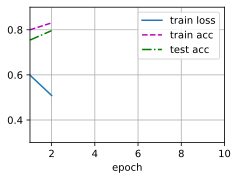

In [19]:
num_epochs = 10
train_ch3( net , train_iter , test_iter , cross_entropy  ,num_epochs ,  updater)

In [ ]:
def predict_ch3( net , test_iter , n = batch_size ):
    for x,y in test_iter:
        break#取出第一个批次的数据
    trues = get_fashion_minst_labels( y )
    predicts = get_fashion_minst_labels( net( x ).argmax( axis = 1 ) )#net(x)返回的batchsize*10的矩阵，一行向量就是一个输出，
                                                                      #我们需要取出每一个输出的最大值的索引，形成一个一维向量
    titles = [ true +'\n'+pred for true , pred in zip( trues , predicts )]
    d2l.show_images(
        x[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

    count = ( y == net( x ).argmax( axis = 1 ) ).sum()
    return count , test_iter.batch_size
predict_ch3( net , test_iter )


* **这里是我的测试片段**

In [ ]:
#测试训练
# def train_mnist(train_iter, loss, updater , flag = False):  #@save
#     """训练模型一个迭代周期（定义见第3章）。"""
#     for X, y in train_iter:
#         y_hat = net(X)
#         l = loss(y_hat, y)
#         if flag:
#                         # 使用PyTorch内置的优化器和损失函数
#             updater.zero_grad()
#             l.backward()
#             updater.step()
#         else:
#             # 计算梯度并更新参数
#             l.sum().backward()
#             updater(X.shape[0])
#     print( f'loss:{l}')

In [ ]:
# net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.normal_(m.weight, std=0.01)

# net.apply(init_weights)
# epochs = 7
# re_updater  = torch.optim.SGD(net.parameters(), lr=0.1)
# re_loss= nn.CrossEntropyLoss()
# for epoch in range( epochs ):
#     train_mnist( train_iter , loss= re_loss , updater= re_updater ,flag=True )
    